# Logistic regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour, plot_slice
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from model_utils import calc_gini_coef, plot_pr_curve, plot_roc_curve

C:\Users\dan\PycharmProjects\ds\ff_internship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from model_utils import split_dataset_v2

# FEATURES_PATH = '../data/features/features_auto_v6.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_filtered_v7.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_boruta_v1.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_elasticnet_v1.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_ga_v1.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_rfe_lgb_v4.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_stable_v2.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_embedded_v6.csv'
# FEATURES_PATH = '../data/features_selected/features_v6_wrappered_v6.csv'

# FEATURES_PATH = '../prod_test/features/features_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_filtered_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc90_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc95_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc98_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_md5_perc100_iter150.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step2_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step5_lgb_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step5_lgb_v1_gain_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_rfe_step5_lgb_v3_gain_v2.csv'
# FEATURES_PATH = '../prod_test/features _v1/features_v1_boruta_perc_100_rfe_step2_lgb_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_pi_nr10_v1.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_shap_v2.csv'
# FEATURES_PATH = '../prod_test/features/features_v1_boruta_perc_100_shap_lgb_v4.csv'

# FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features\features_v1_filtered_v1.csv'
# FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features\features_v1_boruta_md5_perc100_iter150.csv'
FEATURES_PATH = r'C:\Users\dan\PycharmProjects\ds\ff_internship_prod\features\features_v1_final.csv'

X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataset_v2(FEATURES_PATH, valid_size=0.2)

## Hyperparameter tuning

### Bayesian Optimization

In [125]:
def objective(trial):

    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])

    l1_ratio = None
    if solver == 'liblinear':
        # l1_ratio = trial.suggest_categorical('l1_ratio', [0, 1])
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = 'elasticnet'
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        # l1_ratio = 0
        penalty = 'l2'

    # if l1_ratio == 0:
    #     penalty = 'l2'
    # elif l1_ratio == 1:
    #     penalty = 'l1'
    # else:
    #     penalty = 'elasticnet'

    params = {
        'C': trial.suggest_float('C', 1e-4, 1000.0, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'solver': solver,
        'penalty': penalty,
        'l1_ratio': l1_ratio,
        'max_iter': 5000,
        'n_jobs': 6 if solver != 'liblinear' else 1,
        'random_state': 42
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = make_pipeline(
            StandardScaler(),
            LogisticRegression(**params),
        )
        model.fit(X_tr, y_tr)

        y_va_pred_proba = model.predict_proba(X_va)[:, 1]
        va_gini = calc_gini_coef(y_va, y_va_pred_proba)
        scores.append(va_gini)

    return np.mean(scores)


In [126]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=50)

[I 2026-01-23 12:33:29,772] A new study created in memory with name: no-name-f2975042-0564-4707-baf1-07135550d99c
[I 2026-01-23 12:33:30,277] Trial 0 finished with value: 0.5436307500009147 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.6136341713591311, 'class_weight': None}. Best is trial 0 with value: 0.5436307500009147.
[I 2026-01-23 12:33:35,679] Trial 1 finished with value: 0.543552260808158 and parameters: {'solver': 'lbfgs', 'C': 0.47129737561107793, 'class_weight': None}. Best is trial 0 with value: 0.5436307500009147.
[I 2026-01-23 12:33:45,705] Trial 2 finished with value: 0.5435087625970633 and parameters: {'solver': 'saga', 'l1_ratio': 0.19967378215835974, 'C': 0.3977782830811188, 'class_weight': None}. Best is trial 0 with value: 0.5436307500009147.
[I 2026-01-23 12:33:47,487] Trial 3 finished with value: 0.5368035199834493 and parameters: {'solver': 'sag', 'C': 0.013561145768453494, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5436307500009

In [127]:
print('Best score:', study.best_value)
print('Best params:', study.best_params)

Best score: 0.5436632128330764
Best params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 33.19773687865301, 'class_weight': None}


In [128]:
plot_optimization_history(study)

In [129]:
plot_parallel_coordinate(study)

[W 2026-01-23 12:35:21,922] Your study has only completed trials with missing parameters.


In [130]:
plot_slice(study)

In [131]:
plot_param_importances(study)

## Model training and evaluation

In [97]:
# noinspection PyTypeChecker
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        # penalty='elasticnet',
        solver='lbfgs',
        # solver='saga',
        max_iter=5000,
        # class_weight='balanced',
        n_jobs=6,
        random_state=42,
        verbose=1,
    )
)

In [3]:
# Bayesian optimization
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',
        C=33.19774,
        solver='liblinear',
        class_weight=None,
        max_iter=5000,
        n_jobs=1,
        random_state=42,
        verbose=1,
    )
)

In [20]:
model.fit(X_train, y_train)

[LibLinear]

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,33.19774


In [25]:
# y_true = y_train
# y_pred_proba = model.predict_proba(X_train)[:, 1]
# y_true = y_valid
# y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_true = y_test
y_pred_proba = model.predict_proba(X_test)[:, 1]

Gini Coefficient:  0.5503150189201982


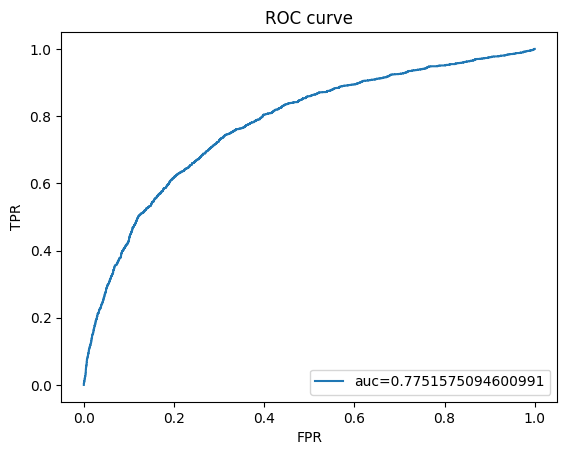

In [26]:
gini_coef = calc_gini_coef(y_true, y_pred_proba)
print('Gini Coefficient: ', gini_coef)

plot_roc_curve(y_true, y_pred_proba)

In [224]:
y_pred = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      5538
           1       0.61      0.37      0.46      1705

    accuracy                           0.80      7243
   macro avg       0.72      0.65      0.67      7243
weighted avg       0.78      0.80      0.78      7243



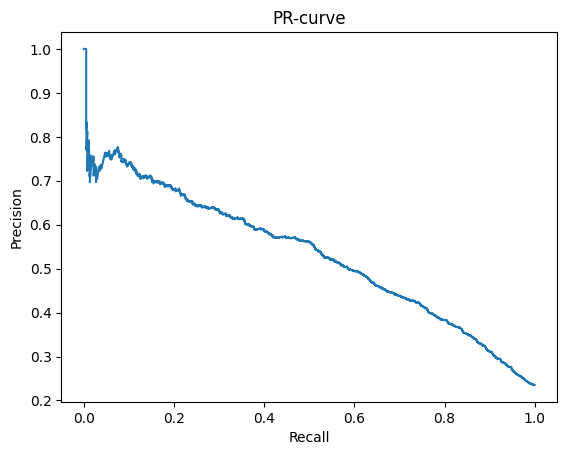

In [27]:
plot_pr_curve(y_true, y_pred_proba)

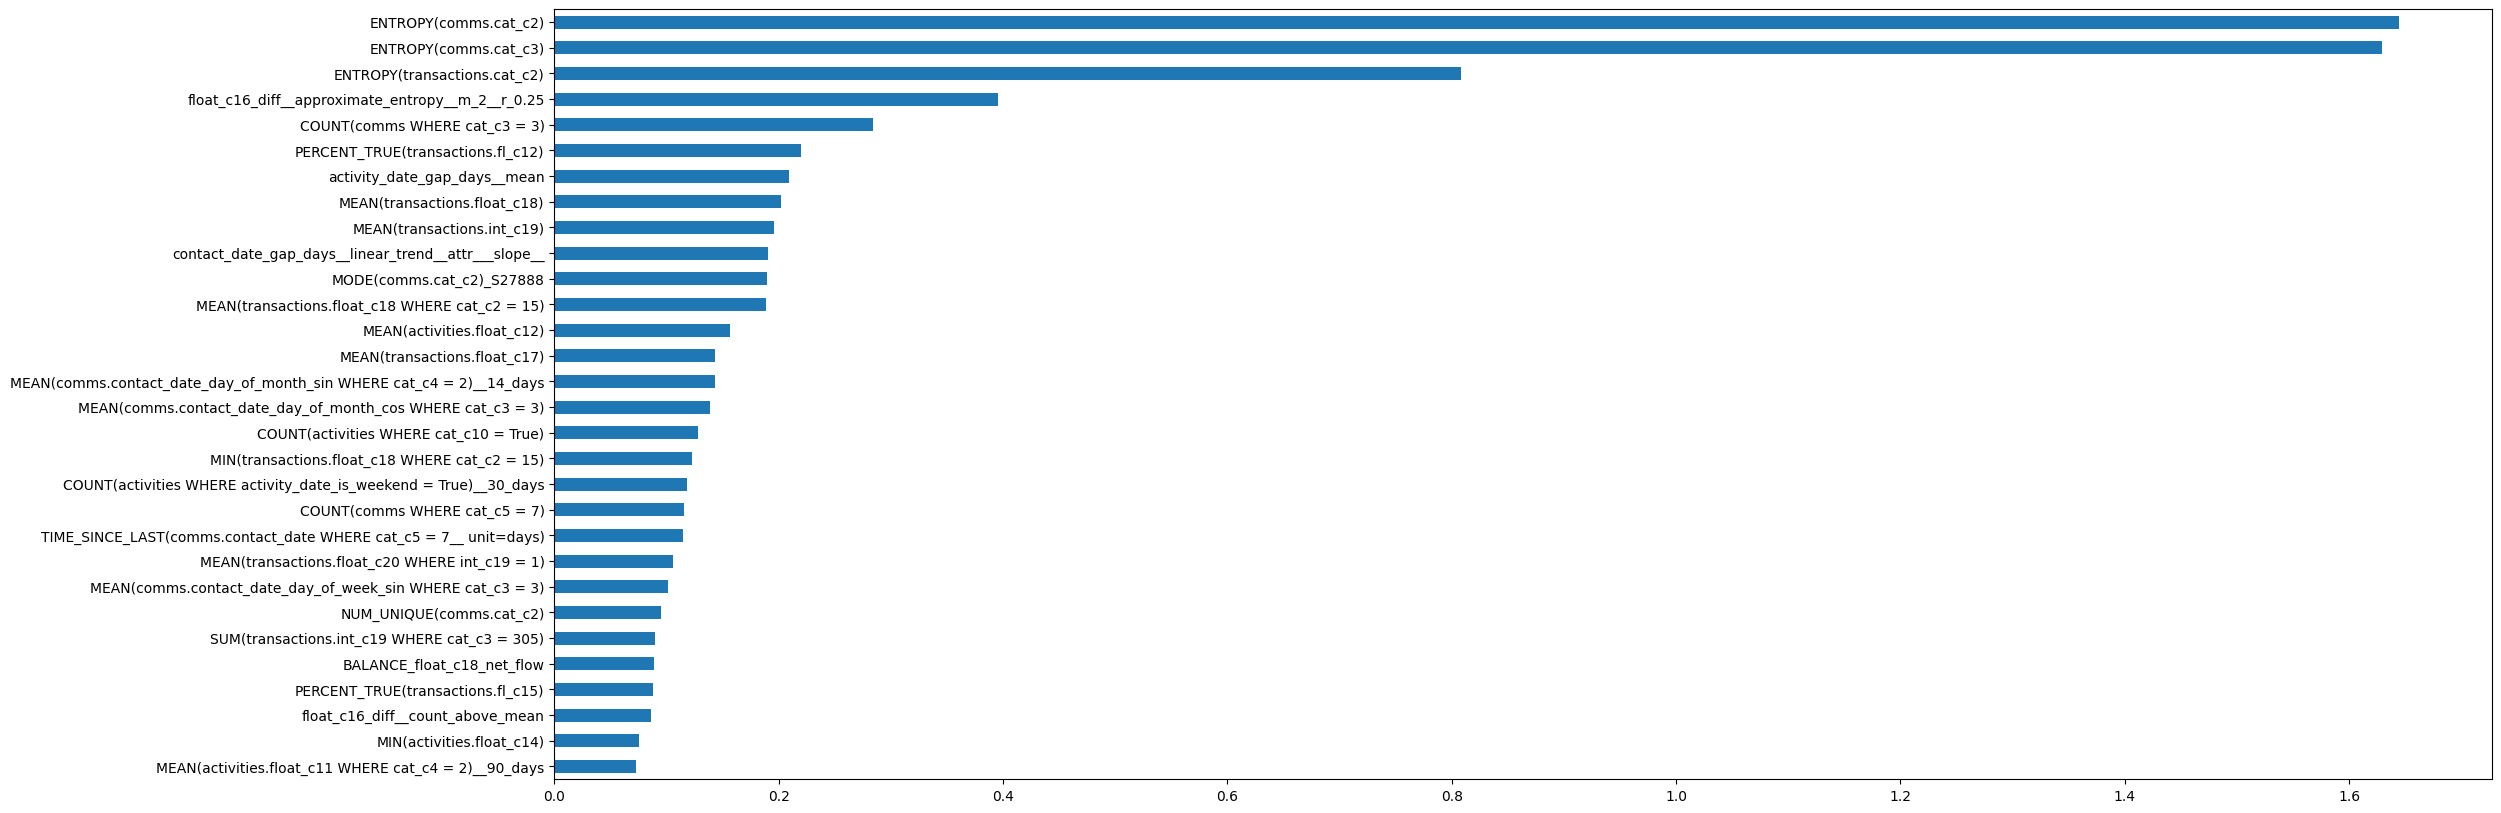

In [28]:
# Feature importance
coefs = model.named_steps['logisticregression'].coef_[0]
features_importance = pd.Series(coefs, index=X_train.columns).map(abs).sort_values(ascending=False)
features_importance.head(30).iloc[::-1].plot(kind='barh', figsize=(25, 10))
# plt.xticks(rotation=45)
plt.show()